In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchsummary
from torch.autograd import Variable
from copy import deepcopy

from PIL import Image

In [2]:
num_epochs = 5
batch_size = 64
num_classes = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.ToTensor()

train_data = datasets.MNIST('./data', train=True, download=True, transform=transform);
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True);

val_data = datasets.MNIST('./data', train=False, download=True, transform=transform);
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False);

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


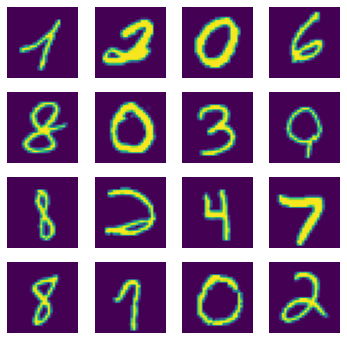

In [4]:
fig = plt.figure(figsize=(6,6))
for i in range(16):
  index = np.random.randint(len(train_data))
  img, label = train_data[index]
  fig.add_subplot(4, 4, i+1)
#  plt.title('label: {}'.format(label))
  plt.axis('off')
  plt.imshow(torch.reshape(img, (28,28)))

###Train autoencoder

In [5]:
def train_autoencoder(model, criterion, optimizer, dataloader, num_epochs=5):
  model.train()
  best_model_wts = deepcopy(model.state_dict())
  best_loss = 10000.
  loss_history = []
  for epoch in range(num_epochs):
    running_loss = 0
    for inputs, _ in dataloader:
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = Variable(inputs.to(device))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(dataloader.dataset)
    loss_history.append(epoch_loss)
    if epoch_loss < best_loss:
        best_model_wts = deepcopy(model.state_dict())
    print('epoch [{}/{}], loss:{:.4f}\n'.format(epoch+1, num_epochs, loss.item()))

  model.load_state_dict(best_model_wts)
  return model, loss_history

In [21]:
class Autoencoder(nn.Module):
  def __init__(self, input_size=28*28):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU())
    self.decoder = nn.Sequential(
        nn.Linear(32,64),
        nn.ReLU(),
        nn.Linear(64, input_size),
        nn.Sigmoid())
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


In [22]:
model = Autoencoder().to(device)
criterion = nn.MSELoss().to(device)

optimiser = optim.Adam(model.parameters(), lr=1e-2)

In [23]:
autoencoder, _ = train_autoencoder(model, criterion, optimiser, train_loader)

epoch [1/10], loss:0.0224

epoch [2/10], loss:0.0214

epoch [3/10], loss:0.0184

epoch [4/10], loss:0.0249

epoch [5/10], loss:0.0210

epoch [6/10], loss:0.0209

epoch [7/10], loss:0.0238

epoch [8/10], loss:0.0204

epoch [9/10], loss:0.0200

epoch [10/10], loss:0.0226



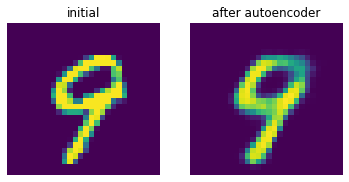

In [29]:
fig = plt.figure(figsize=(6,3))
fig.add_subplot(1, 2, 1)
index = np.random.randint(len(val_data))
img, _ = val_data[index]
plt.title('initial')
plt.axis('off')
plt.imshow(torch.reshape(img, (28,28)));

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = autoencoder(img.view(img.shape[0], -1))
img_encoded = torch.reshape(img_encoded, (28, 28))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach());

###Train classifier

In [10]:
def train_classifier(classifier, autoencoder, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=10):

  for param in autoencoder.parameters():
    param.requires_grad = False

  best_model_wts = deepcopy(classifier.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_correct = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = Variable(inputs.to(device))
        labels = Variable(labels.to(device))
        optimizer.zero_grad()

        logits = autoencoder.encoder(inputs)
        semantic = logits[:, :10]

        outputs = classifier(semantic)
        _, preds = torch.max(outputs, 1)  
        loss = criterion(outputs, labels)
        if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(labels == preds.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_correct.double() / dataset_sizes[phase]

      if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(classifier.state_dict())

      print('{} epoch [{}/{}], loss: {:.4f}, acc: {:.4f}'.format(
                phase, epoch+1, num_epochs, epoch_loss, epoch_acc))
    print()

  classifier.load_state_dict(best_model_wts)
  return classifier

In [34]:
model = nn.Sequential(nn.Linear(10,32),nn.ReLU(), nn.Linear(32,10)).to(device)
#model = nn.Sequential(nn.Linear(10,10)).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
#optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [35]:
classifier = train_classifier(model, autoencoder, criterion, optimizer, dataloaders, dataset_sizes)

train epoch [1/10], loss: 1.0058, acc: 0.6548
val epoch [1/10], loss: 0.8475, acc: 0.7085

train epoch [2/10], loss: 0.8801, acc: 0.6969
val epoch [2/10], loss: 0.8481, acc: 0.7104

train epoch [3/10], loss: 0.8607, acc: 0.7016
val epoch [3/10], loss: 0.8254, acc: 0.7198

train epoch [4/10], loss: 0.8482, acc: 0.7075
val epoch [4/10], loss: 0.8561, acc: 0.7036

train epoch [5/10], loss: 0.8434, acc: 0.7091
val epoch [5/10], loss: 0.8290, acc: 0.7117

train epoch [6/10], loss: 0.8403, acc: 0.7115
val epoch [6/10], loss: 0.8251, acc: 0.7145

train epoch [7/10], loss: 0.8378, acc: 0.7113
val epoch [7/10], loss: 0.8347, acc: 0.7145

train epoch [8/10], loss: 0.8351, acc: 0.7126
val epoch [8/10], loss: 0.8115, acc: 0.7207

train epoch [9/10], loss: 0.8352, acc: 0.7126
val epoch [9/10], loss: 0.8240, acc: 0.7151

train epoch [10/10], loss: 0.8354, acc: 0.7108
val epoch [10/10], loss: 0.8106, acc: 0.7188



In [94]:
def classifier_prediction(img):
  # input is (28, 28) or (1, 28, 28) tensor
  img = torch.reshape(img, (1, 28*28))
  semantic = autoencoder.encoder(img)[:,:10]
  output = classifier(semantic)
  _, preds = torch.max(output, 1)

  return preds.item()


### Attack it

In [36]:
def attack(model, input, target, num_iter, alpha):
  model.eval()
  with torch.set_grad_enabled(True):
    img = deepcopy(input)
    output_targ = model(target)[:, :10]
    best_loss = 10000.
    best_img = deepcopy(img)
    img = Variable(img, requires_grad=True)
    for i in range(num_iter):
      
      output = model(img)[:, :10]
      loss = torch.norm(output - output_targ, p=2)
      loss.backward(retain_graph=True)

      if loss.item() < best_loss:
        best_loss = loss.item()
        best_img = deepcopy(img)
      
      #step
      img.data -= alpha * torch.sign(img.grad.data)

  return best_img, best_loss

classifier_prediction:  6


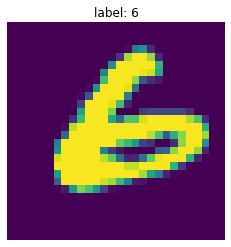

In [87]:
index1 = np.random.randint(len(val_loader.dataset))
img1, label1 = val_loader.dataset[index1]
plt.title('label: {}'.format(label1))
plt.axis('off')
plt.imshow(torch.reshape(img1, (28,28)));

print("classifier_prediction: ", classifier_prediction(img1))

classifier_prediction:  8


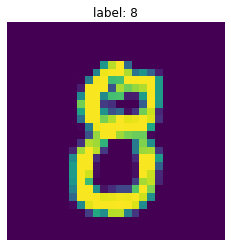

In [38]:
index2 = np.random.randint(len(val_loader.dataset))
img2, label2 = val_loader.dataset[index2]
plt.title('label: {}'.format(label2))
plt.axis('off')
plt.imshow(torch.reshape(img2, (28,28)));

print("classifier_prediction: ", classifier_prediction(img2))

classifier_prediction:  8


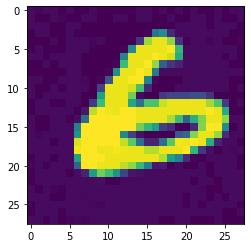

In [91]:
adv, _ = attack(autoencoder.encoder, torch.reshape(img1, (1, 28*28)),
                torch.reshape(img2, (1, 28*28)), 5, 1./255)

plt.imshow(torch.reshape(adv, (28, 28)).detach());
print("classifier_prediction: ", classifier_prediction(adv))

### JPEG for MNIST

In [40]:
def to_jpg_and_back(img):
  img = img.data.cpu().numpy()

  #make jpg
  img = img * 255.0
  img = np.clip(img, 0, 255).astype(np.uint8)
  img_pil = torchvision.transforms.ToPILImage()(img)
  img_pil.save('img.jpg', 'JPEG')

  #back to tensor
  img_back = (np.asarray(Image.open('img.jpg')) / 255.0).astype(np.float32)
  transform = transforms.ToTensor()
  img_back = transform(img_back)
  img_back = torch.reshape(img_back, (1, 28, 28))
  
  return img_back

classifier prediction:  8


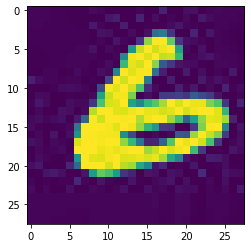

In [102]:
adv_jpg = to_jpg_and_back(torch.reshape(adv, (28, 28)))
plt.imshow(adv_jpg[0])

print('classifier prediction: ', classifier_prediction(adv_jpg))